# Inverse UQ of 'a' and 'm' parameter

In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [2]:
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using .Src, DataFrames, Optim, ForwardDiff, LinearAlgebra, CSV, Plots

## Tools

In [3]:
"""
    function compute_ll_am(x, hprm::Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

compute the log-likelihood in least-squares form for Klausmeier model for data with Gaussian noise. First, simulate Klausmeier model for given hyperparameters and noise level. Then, compare to true trajectories.
x contains the parameters of interest, which should be inferred.

# Arguments
- `x`: variables with respect to which likelihood is computed
- `hprm::Hyperprm`: parameters for which the Klausmeier simulation is performed
- `true_val::DataFrame`: observed data trajectories. DataFrame with columns "w" and "n".
- `t_fixed::Bool`: true if we consider a fixed observation time window
- `t_end::Float64`: end of observation window (if t_fixed=true)
- `t_step::Float64`: step size with which M observations should be picked (set if t_fixed=false)

# Returns
- `Float`: scalar value of log-likelihood at given grid point 
"""
function compute_ll_am(x, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    a, m = x
    hprm = Src.Hyperprm(hprm.w0, hprm.n0, a, m, hprm.M, hprm.noise)
    pred_val = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end,t_step=t_step)
    if hprm.noise == 0.0
        ll = -0.5 * sum((true_val[:,"n"] - pred_val[:,"n"]) .^2) - 0.5 * sum((true_val[:,"w"] - pred_val[:,"w"]) .^2) # add up ll for both trajectories
    else
        ll = -0.5 * 1/hprm.noise * sum((true_val[:,"n"] - pred_val[:,"n"]) .^2) - 0.5 * 1/hprm.noise * sum((true_val[:,"w"] - pred_val[:,"w"]) .^2) # add up ll for both trajectories
    end
    return ll
end

"""
    function compute_mle(hprm::Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

compute the maximum likelihood estimate given data observations by minimizing the negative log-likelihood function using the Optim.jl package.
The initialization point is chosen as the true parameter combination underlying the data observation to ensure fast convergence to global minimum.
The minimization method is chosen by default.

# Returns
- `Vector{Float64}`: 2-element vector containing the mle [a_mle, n0_mle]
- `Bool`: true if optimization was successfull
"""
function compute_mle_am(hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0, N::Int64=5)
    inits, inits_loss, mles, losses, best_loss_ind, converged = mult_restart_mle_am(N, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step)
    return mles[best_loss_ind, :], converged[best_loss_ind]
end

"""
    function mult_restart_mle(N::Int64, hprm::Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

Perform Maximum Likelihood estimation for N different starting points. Goal is to find global minimum

# Inputs
    - `N::Int64`: number of restarts

# Returns
    - `Matrix`: initial values used in optimization
    - `Vector`: losses of initial values
    - `Matrix`: computed MLEs
    - `Vector`: corresponding losses of MLEs
    - `Int`: index of optimization trial creating minimal loss
    - `Vector`: convergence status for each optimization trial
"""
function mult_restart_mle_am(N::Int64, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    # generate optim start pts
    inits = hcat(2 .* rand(N), 4 .* rand(N))

    # store mles and corresponding loss
    mle_vals = zeros(N, 2)
    mle_loss, inits_loss, converged = zeros(N), zeros(N), zeros(N)

    for i in 1:N
        pt = inits[i,:] # starting point for optimization
        result = optimize(x -> - compute_ll_am(x, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step), pt)
        #display(result)
        mle_vals[i,:] = Optim.minimizer(result)
        mle_loss[i] =  Optim.minimum(result)
        converged[i] = Optim.converged(result)
        inits_loss[i] = -compute_ll_am(pt, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step)
    end

    # extract best
    best_loss, best_loss_ind = findmin(mle_loss)

    return inits, inits_loss, mle_vals, mle_loss, best_loss_ind, converged
end

mult_restart_mle_am

In [4]:
"""
    function gen_ll_evals_for_hprm_comb(hprm_true::Hyperprm; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

evaluates log-likelihood on grid for one (a,n0,M,noise) hyperprm combination. Run this for all hyperprm combinations wanted, helper function

# Arguments
- `hprm::Hyperprm`: parameters for which the Klausmeier simulation is performed
- `true_val::DataFrame`: true data trajectories. DataFrame with columns "w" and "n".
- `t_fixed::Bool`: true if we consider a fixed observation time window
- `t_end::Float64`: end of observation window (if t_fixed=true)
- `t_step::Float64`: step size with which M observations should be picked (set if t_fixed=false)

# Returns
-`DataFrame`: DataFrame of log-likelihood evaluated on grid for given parameter combination
"""
function gen_ll_evals_for_am_comb(hprm_true::Src.Hyperprm; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

    #grid = [(a, m) for m in 0.0:0.05:1.0, a in 0.0:0.05:2.0]
    grid = [(a, m) for m in 0.0:0.05:1.0, a in 0.0:0.1:2.0]
    sol_true = Src.sol_klausmeier(hprm_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step) # returns df
    sol_true = Src.randomize_data!(sol_true, hprm_true.noise) # include noise

    #ll = zeros(21, 41)
    ll = zeros(21, 21)

    for i in range(1, 21)
        #for j in range(1, 41) #eval for each point on grid
        for j in range(1, 21) 
            pt = grid[i,j] # pt = (a,m)
            ll[i,j] = compute_ll_am(pt, hprm_true, sol_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step)
        end
    end
    
    #return data frame
    #a_eval_pts = string.(0.0:0.05:2.0)
    a_eval_pts = string.(0.0:0.1:2.0)
    df_ll = DataFrame(ll, a_eval_pts)

    return df_ll
end

"""
    function gen_all_ll_data(points::Vector{Vector{Int64}}, M_vals::Vector{Int64}, noise_vals::Vector{Float64}, m::Float64, w0::Float64, path::String; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

function that generates and stores all the ll data needed. On all a,n0,M,noise prm combinations specifed.

# Arguments
- `points::Vector{Vector{Int64}}`: parameter points underlying true data observations.
- `M_val::Vector{Int64}`: sample sizes
- `noise_vals::Vector{Float64}`: noise levels
- `m::Float64`: mortality rate in Klausmeier model (fixed)
- `w0::Float64`: initial value for water compartment in Klausmeier model (fixed)
- `path::String`: path to folder where ll data is stored
- `t_fixed::Bool`: true if we consider a fixed observation time window
- `t_end::Float64`: end of observation window (if t_fixed=true)
- `t_step::Float64`: step size with which M observations should be picked (set if t_fixed=false)
"""
function gen_all_ll_data_am(points::Vector{Vector{Float64}}, M_vals::Vector{Int64}, noise_vals::Vector{Float64}, n0::Float64, w0::Float64, path::String; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    for pt in points
        for M in M_vals
            for noise in noise_vals
                a, m = pt
                hprm = Src.Hyperprm(w0,n0,a,m,M,noise)
                df_ll = gen_ll_evals_for_am_comb(hprm, t_fixed=t_fixed, t_end=t_end, t_step=t_step)
                Src.store_ll_data(w0,n0,a,m,M,noise,df_ll,path)
            end
        end
    end

end

gen_all_ll_data_am

In [5]:
"""
    function compute_fi_am(eval_pt::Vector{Float64}, hprm::Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

compute the Fisher information at evaluation point. The Fisher information is given by the trace of the negative Hessian of the log-likelihood function.

# Returns
- `Float64`: Fisher information value at given evaluation point
"""
function compute_fi_am(eval_pt::Vector{Float64}, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    H = ForwardDiff.hessian(x -> compute_ll_am(x, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step), eval_pt)
    return tr(-H)
end

"""
    function store_fish_data(w0::Float64,m::Float64,M::Int64,noise::Float64,df::DataFrame, path::String)

stores data evaluated on grid in a csv file.
Name of form "fish_w0_n0_a_m_M_noise.csv"

# Arguments
- `df::DataFrame`: df to store
- `path_to_repo::String`: path to folder where to store the file
"""
function store_fish_data(w0::Float64,m::Float64,M::Int64,noise::Float64,df::DataFrame, path::String)
    CSV.write("$(path)fish_$(w0)_$(m)_$(M)_$(noise).csv", df)
end

"""
    function gen_all_fish_data(M_vals, noise_vals, m, w0, path; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)

function that generates and stores all the fish data needed. On all a,n0,M,noise prm combinations specifed.

# Arguments
- `M_val::Vector{Int64}`: sample sizes
- `noise_vals::Vector{Float64}`: noise levels
- `m::Float64`: mortality rate in Klausmeier model (fixed)
- `w0::Float64`: initial value for water compartment in Klausmeier model (fixed)
- `path::String`: path to folder where fish data is stored
- `t_fixed::Bool`: true if we consider a fixed observation time window
- `t_end::Float64`: end of observation window (if t_fixed=true)
- `t_step::Float64`: step size with which M observations should be picked (set if t_fixed=false)
"""
function gen_all_fish_data(M_vals, noise_vals, m, w0, path; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    for M in M_vals
        for noise in noise_vals

            grid = Src.create_grid()
            fish = zeros(41, 21)

            # keep track of whether the optimization algo terminates successfully when finding the MLE
            success_counter = 0
            eval_pt_counter = 0

            # evaluate fisher info on grid
            for i in range(1, 41)
                for j in range(1, 21)
                    eval_pt_counter = eval_pt_counter + 1 # total number of optimizations

                    pt = grid[i,j] # true observation parameter point
                    hprm = Src.Hyperprm(w0, pt[2], pt[1], m, M, noise) # w0,n0,a,m,M

                    sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end, t_step=t_step)
                    sol_true = Src.randomize_data!(sol_true, hprm.noise) # include noise

                    mle, success = compute_mle_am(hprm, sol_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step)

                    # evaluate Fi at MLE
                    fish[i,j] = compute_fi_am(mle, hprm, sol_true; t_fixed=t_fixed, t_end=t_end, t_step=t_step)

                    success_counter = success_counter + success # number of successfull optimizations
                end
            end

            success_fraction = success_counter / eval_pt_counter
            println("MLE terminated with success in $success_fraction cases.")
            
            # create data frame
            a_eval_pts = string.(0.0:0.1:2.0)
            df_fish = DataFrame(fish, a_eval_pts)

            store_fish_data(w0, m, M, noise, df_fish, path)
        end
    end
end

gen_all_fish_data

## infer a,m with fisher inversion

we infer a,m for different combinations of observed (a,m,n0) tuples.

In [6]:
# general setup
t_fixed = true
t_end = 100.0;

In [7]:
path = "C:/Users/lisah/Documents/Repos/ma-code/data/t_fixed/t100/fisher_am/"
noise_vals = [0.0, 0.01, 0.1, 0.5,  1.0, 2.0]
#M_vals = [50,100,500,1000]
M_vals = [10]
w0 = 0.95
m = 0.45 # m of data observations is always 0.45

#gen_all_fish_data(M_vals, noise_vals, m, w0, path, t_fixed=t_fixed, t_end=t_end)

MLE terminated with success in 1.0 cases.
MLE terminated with success in 1.0 cases.
MLE terminated with success in 1.0 cases.
MLE terminated with success in 1.0 cases.
MLE terminated with success in 0.9883855981416957 cases.
MLE terminated with success in 0.9767711962833914 cases.


Plots are analyzed in "notebooks\playground\infer_am\plots_inverse_uq_am.ipynb".

We analyze the identifiability of the following points:
1. a = 0.3, m = 0.45, n0 = 1.5
2. a = 0.9, m = 0.45, n0 = 1.5
3. a = 1.5, m = 0.45, n0 = 1.5

## Generate likelihood data at points

In [8]:
# set global parameters
m_true = 0.45
n0_true = 1.5
w0 = 0.95;

In [10]:
points = [[0.3,0.45],[0.9,0.45],[1.5,0.45]]
M_vals = [1000, 500, 100, 50, 10]
noise_vals = [0.0, 0.01, 0.1, 0.5, 1.0, 2.0]
path = "C:/Users/lisah/Documents/Repos/ma-code/data/t_fixed/t100/likelihood_am/"

gen_all_ll_data_am(points, M_vals, noise_vals, n0_true, w0, path, t_fixed=t_fixed, t_end=t_end)

## Practical identifiability

In [ ]:
t_fixed = true
t_end = 100.0;

In [68]:
# set global parameters
m_true = 0.45
n0_true = 1.5
w0 = 0.95
M = 10
noise = 0.0;

### Tools

In [289]:
function plot_mult_restart_mles(inits::Matrix, mles::Matrix, ind_best::Int64; compare::Bool=true)
    N = size(mles, 1)
    plot(mles[:,1], label="MLEs", title="Multiple restart MLE of a",color=:orange, ylabel="parameter value", xlabel="restart index")
    hline!([hprm.a], linestyle=:dash, linewidth=2, color=:black,  label="true parameter")
    scatter!(1:N, mles[:,1], markershape=:square, markersize=2, color=:orange, label="")

    if compare
        plot!(inits[:,1], label="inits", color=:blue)
        scatter!(1:N, inits[:,1], markershape=:square, markersize=2, color=:blue, label="")
    end
    scatter!([best_loss_ind], [mles[best_loss_ind, 1]], markershape=:x, markerstrokewidth=4, markersize=6, color=:red, label="best estimate")
end

function plot_mult_restart_losses(inits_loss::Vector, losses::Vector, ind_best::Int64; compare::Bool=true)
    N = length(losses)
    plot(losses, label="MLEs", color=:darkorange, title="Loss evolution of multiple restart MLE", ylabel = "loss value", xlabel="restart index")
    scatter!(1:N, losses, markershape=:square, markersize=2, color=:darkorange, label="")

    if compare
        plot!(inits_loss, label="init", color=:blue)
        scatter!(1:N, inits_loss, markershape=:square, markersize=2, color=:blue, label="")
    end

    scatter!([best_loss_ind], [losses[best_loss_ind]], markershape=:x, markerstrokewidth=4, markersize=6, color=:red, label="lowest")
end

function correlation_matrix(eval_pt::Vector{Float64}, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    fim = - ForwardDiff.hessian(x -> compute_ll_am(x, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step), eval_pt)
    cov = inv(fim)
    cor = [cov[i,j] / sqrt(cov[i,i]*cov[j,j]) for i in range(1, size(cov,1)), j in range(1, size(cov,2))]
    return cor
end

correlation_matrix (generic function with 10 methods)

### 1. Left of bifurcation point

In [29]:
a_true = 0.3
hprm = Src.Hyperprm(w0, n0_true, a_true, m_true, M, noise)

# generate true data, i.e. data observations
sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end) 
sol_true = Src.randomize_data!(sol_true, hprm.noise); # make data noisy

#### Multiple restart optim

In [291]:
N = 20
inits, inits_loss, mles, losses, best_loss_ind, converged = mult_restart_mle_am(N, hprm, sol_true, t_fixed=t_fixed, t_end=t_end);

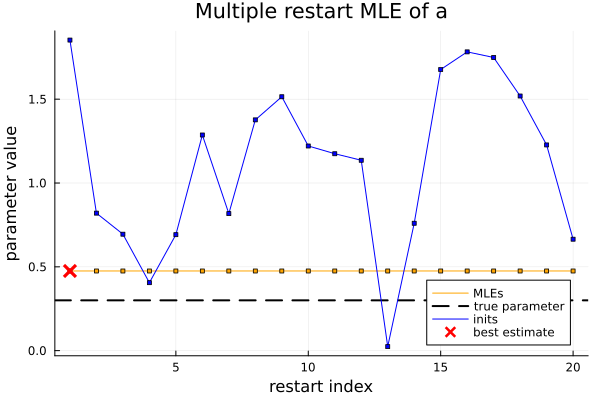

In [292]:
# plot inits vs. mles
plot_mult_restart_mles(inits, mles, best_loss_ind)

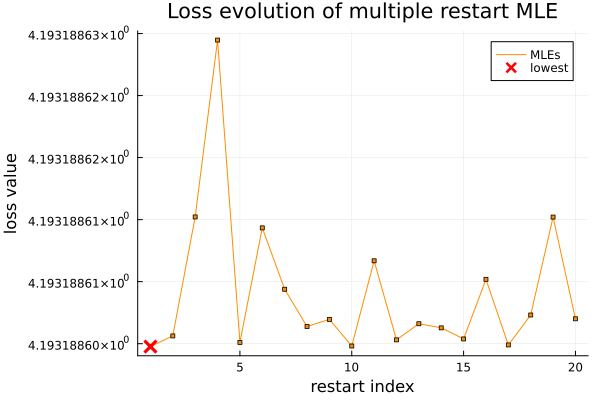

In [293]:
plot_mult_restart_losses(inits_loss, losses, best_loss_ind, compare=false)

#### Correlation matrix of MLEs

In [294]:
mle_pt = mles[best_loss_ind,:]

2-element Vector{Float64}:
 0.4752076106275386
 0.4264399747443169

In [295]:
correlation_matrix(mle_pt, hprm, sol_true, t_fixed=t_fixed, t_end=t_end)

2×2 Matrix{Float64}:
 1.0       0.528951
 0.528951  1.0

### 2. At bifurcation point

In [297]:
a_true = 0.9
hprm = Src.Hyperprm(w0, n0_true, a_true, m_true, M, noise)

# generate true data, i.e. data observations
sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end) 
sol_true = Src.randomize_data!(sol_true, hprm.noise); # make data noisy

#### Multiple restart optim

In [298]:
N = 20
inits, inits_loss, mles, losses, best_loss_ind, converged = mult_restart_mle_am(N, hprm, sol_true, t_fixed=t_fixed, t_end=t_end);

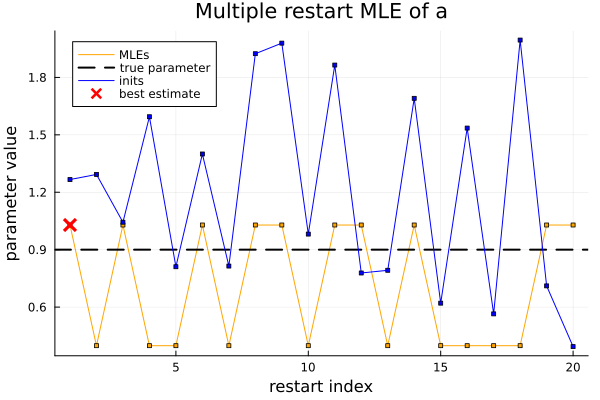

In [299]:
# plot inits vs. mles
plot_mult_restart_mles(inits, mles, best_loss_ind)

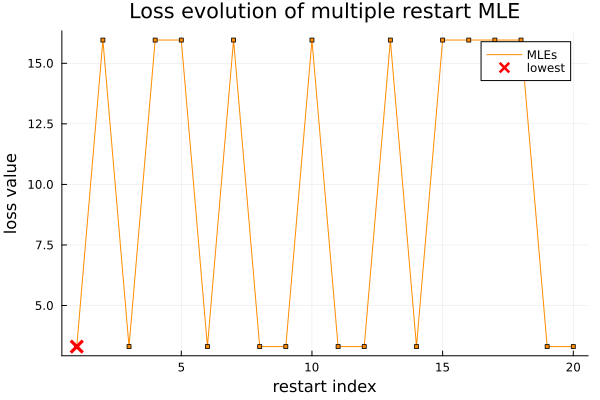

In [300]:
plot_mult_restart_losses(inits_loss, losses, best_loss_ind, compare=false)

#### Correlation matrix of MLEs

In [301]:
mle_pt = mles[best_loss_ind,:]


2-element Vector{Float64}:
 1.0289143241931493
 0.5095834492554681

In [302]:
correlation_matrix(mle_pt, hprm, sol_true, t_fixed=t_fixed, t_end=t_end)

2×2 Matrix{Float64}:
 1.0       0.998026
 0.998026  1.0

### 3. Right of bifurcation point

In [304]:
a_true = 1.5
hprm = Src.Hyperprm(w0, n0_true, a_true, m_true, M, noise)

# generate true data, i.e. data observations
sol_true = Src.sol_klausmeier(hprm; t_fixed=t_fixed, t_end=t_end) 
sol_true = Src.randomize_data!(sol_true, hprm.noise); # make data noisy

#### Multiple restart optim

In [305]:
N = 20
inits, inits_loss, mles, losses, best_loss_ind, converged = mult_restart_mle_am(N, hprm, sol_true, t_fixed=t_fixed, t_end=t_end);

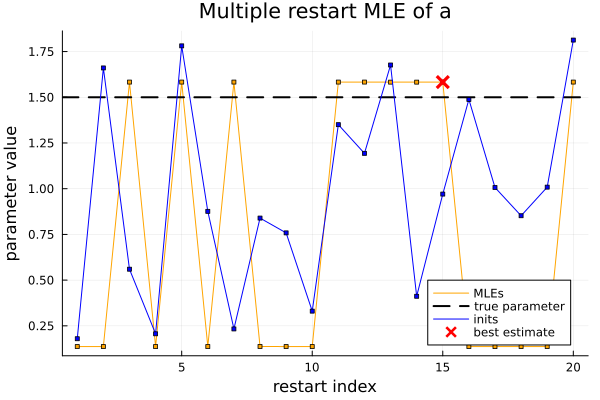

In [306]:
# plot inits vs. mles
plot_mult_restart_mles(inits, mles, best_loss_ind)

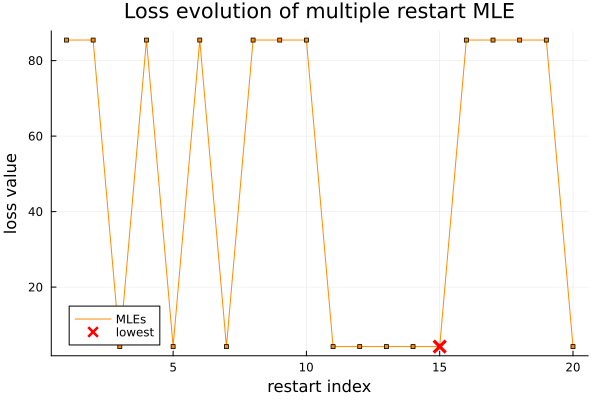

In [307]:
plot_mult_restart_losses(inits_loss, losses, best_loss_ind, compare=false)

#### Correlation matrix of MLEs

In [308]:
mle_pt = mles[best_loss_ind,:]


2-element Vector{Float64}:
 1.5829826024799645
 0.4727484169706181

In [309]:
correlation_matrix(mle_pt, hprm, sol_true, t_fixed=t_fixed, t_end=t_end)

2×2 Matrix{Float64}:
 1.0      0.99837
 0.99837  1.0